# KorQuAD with BERT
---

BERT 모델을 통하여 KorQuAD 태스크를 풀어보자. 이 과정에서 pretrained model을 활용하여 보고 활용 전후의 성능 차이를 확인하여 본다.

## STEP 0. 설계
---

1. 데이터 전처리
    - KorQuAD 데이터셋을 다운로드 받아 전처리를 진행한다.
    - 전처리는 다음과 같은 내용을 포함한다.
        - 띄워 쓰기 단위로 문장 분리 -> `_tokenize_whitespace`
        - SentencePiece 모델을 이용한 Subword 기반의 텍스트 전처리 -> `_tokenize_vocab`
        - 지문(context)에서 질문(question)의 답(answer)에 해당하는 영역 찾기 -> `_improve_span`
2. 데이터 분석
    - 전처리된 데이터를 question/context/answer로 나누어 데이터에 이상치가 있는지 확인한다.
    - 분석에서 확인해볼만한 사항은 다음과 같다.
        - question의 문장 길이의 최대/최소/평균/표준편차/백분위수/IQR
        - context의 문장 길이의 최대/최소/평균/표준편차/백분위수/IQR
        - answer의 위치의 최대/최소/평균/표준편차/백분위수/IQR
3. 모델 설계
    - Token Embedding, Segment Embedding, Position Embedding으로 구성된 BERT 모델을 설계한다.
    - 모델 설계를 위하여 각 레이어를 정의한다.
4. 모델 정의
    - 학습되지않은 BERT 모델과 Pretrained model을 로드한 BERT 모델을 정의한다.
5. 모델 학습
    - 모델을 학습하고 학습 경과를 출력하여 본다.
6. 모델 평가
    - 램덤하게 뽑은 테스트셋을 이용하여 Inference 수행한다.
    - 학습한 두 모델의 Inference 결과를 비교하여 본다.

#### 환경설정

- 한글폰트 확인

In [6]:
# 한국어 폰트 설치를 확인합니다.  
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

- load package

In [7]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

- init gpu

In [8]:
import tensorflow as tf

# initialization gpu ########################################################
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




- set path variable

In [9]:
workspace_dir = os.getenv('HOME')+'/workspace/aiffel-exploration-workspace/E19_BERT'
data_dir = workspace_dir + '/data'
model_dir = workspace_dir + '/models'

train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'

## STEP 1. 데이터 전처리
---

### 0. 데이터 로드

In [10]:
# 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)

### 1. 띄어쓰기 단위 정보관리

In [11]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [12]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

### 2. Tokenize by Vocab

In [13]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [14]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

### 3. Improve Span

In [15]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

### 4. 데이터셋 분리

train 데이터셋, dev 데이터셋을 분리하여, 위에서 작성한 `_improve_span()` 함수를 이용해 전처리 후 파일로 저장합니다.

In [16]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [17]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

## STEP 2. 데이터 분석
---

- load data

In [18]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])

In [19]:
len(questions), len(contexts), len(token_starts)

(60407, 60407, 60407)

### 1. Question

- question 항목의 길이 분포를 조사

In [20]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

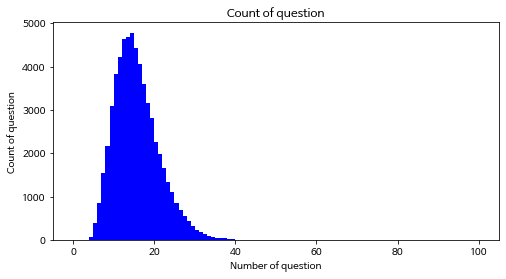

In [21]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [22]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


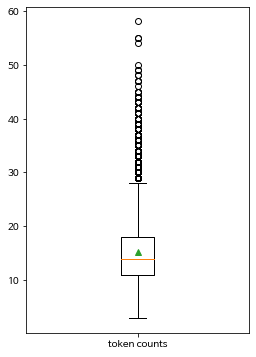

In [23]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

### 2. Context

In [24]:
# token count
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

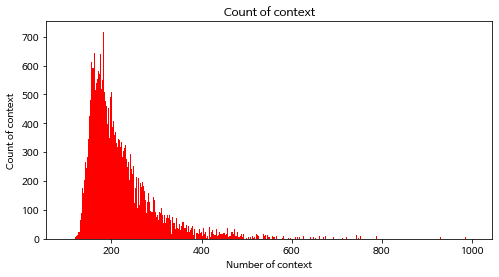

In [25]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
# 그래프 제목
plt.title('Count of context')
# 그래프 x 축 라벨
plt.xlabel('Number of context')
# 그래프 y 축 라벨
plt.ylabel('Count of context')
plt.show()

In [26]:
# 데이터 길이
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50


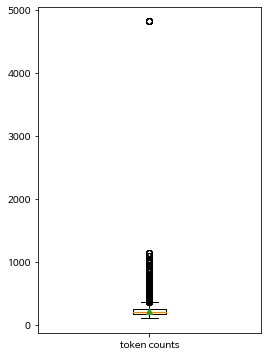

In [27]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

### 3. Answer

In [28]:
# token count
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

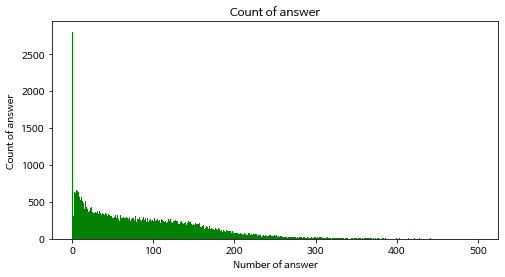

In [29]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
# 그래프 제목
plt.title('Count of answer')
# 그래프 x 축 라벨
plt.xlabel('Number of answer')
# 그래프 y 축 라벨
plt.ylabel('Count of answer')
plt.show()

In [30]:
# 데이터 길이
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


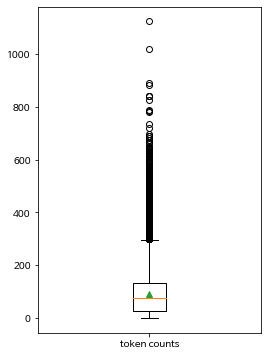

In [31]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

### 4. Word Cloud

In [32]:
# train documents
documents = []

# 전체 데이터에서 title, context, question 문장을 모두 추출합니다. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # 그중 맨 앞 10개만 확인해 봅니다.

  0%|          | 0/1420 [00:00<?, ?it/s]

['파우스트_서곡',
 '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?',
 '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?',
 '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?',
 '바그너가 파우스트를 처음으로 읽은 년도는?',
 '바그너가 처음 교향곡 작곡을 한 장소는?',
 '바그너의 1악장의 초연은 어디서 연주되었는가?']

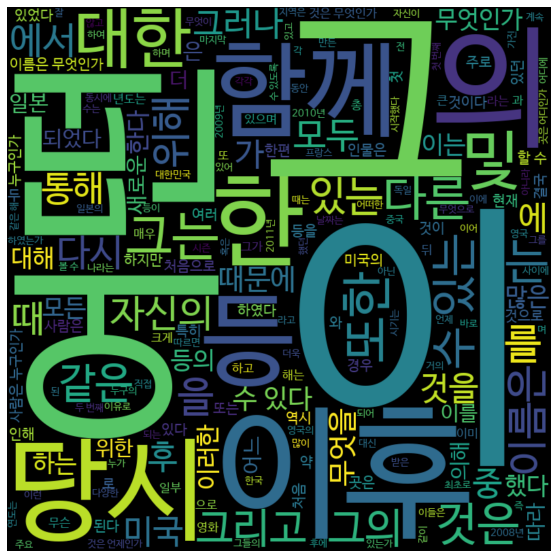

In [33]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

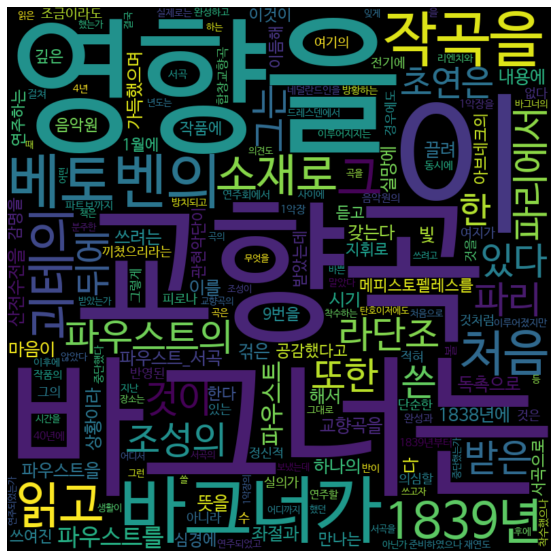

In [34]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents[:10]))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 5. 데이터 로드

In [35]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [36]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [37]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [38]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

## STEP 3. 모델 설계
---

In [39]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [40]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [41]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [42]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [43]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [44]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [45]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [46]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [47]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

## STEP 4. 모델 정의
---

In [59]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

### 1. BERT model

In [21]:
model = BERT4KorQuAD(config)

### 2. Pretrained model

In [49]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

pretrained_model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    pretrained_model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    pretrained_model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    pretrained_model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_18 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


## STEP 5. 모델 학습
---

### 1. dataset 정의

In [50]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

### 2. Train function 정의

In [51]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [52]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [53]:
def train(model, train_dataset, dev_dataset, save_path):
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy
    acc_fn = tf.keras.metrics.sparse_categorical_accuracy

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
    history = {
        'train_loss' : [],
        'train_acc' : [],
        'val_loss' : [],
        'val_acc': []
    }

    best_acc = .0
    patience = 0
    for epoch in range(20):
        _, train_loss, _, train_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
        start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)

        history['train_loss'].append(train_loss.numpy())
        history['train_acc'].append(train_acc.numpy())
        history['val_loss'].append(end_loss.numpy())
        history['val_acc'].append(end_acc.numpy())

        print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
        acc = start_acc + end_acc
        if best_acc < acc:
            patience = 0
            best_acc = acc
            model.save_weights(save_path)
            print(f'save best model')
        else:
            patience += 1
        if 5 <= patience:
            print(f'early stopping')
            break
    
    return history

### 3. 모델 학습

In [65]:
history = train(model, 
                train_dataset, 
                dev_dataset, 
                os.path.join(data_dir, "korquad_bert_no_pretrain.hdf5"))

0it [00:00, ?it/s]

eval 0 >> loss: 3.6510, 4.2305, acc: 0.1303, 0.1025
save best model


0it [00:00, ?it/s]

eval 1 >> loss: 3.5638, 4.1130, acc: 0.1531, 0.1304
save best model


0it [00:00, ?it/s]

eval 2 >> loss: 3.6284, 4.1824, acc: 0.1638, 0.1483
save best model


0it [00:00, ?it/s]

eval 3 >> loss: 3.7043, 4.3349, acc: 0.1634, 0.1491
save best model


0it [00:00, ?it/s]

eval 4 >> loss: 3.8241, 4.4711, acc: 0.1587, 0.1434


0it [00:00, ?it/s]

eval 5 >> loss: 4.0252, 4.6763, acc: 0.1485, 0.1455


0it [00:00, ?it/s]

eval 6 >> loss: 4.3951, 5.4090, acc: 0.1419, 0.1396


0it [00:00, ?it/s]

eval 7 >> loss: 4.7958, 5.7679, acc: 0.1371, 0.1373


0it [00:00, ?it/s]

eval 8 >> loss: 5.0444, 6.2810, acc: 0.1266, 0.1262
early stopping


In [54]:
pretrained_history = train(pretrained_model, 
                           train_dataset, 
                           dev_dataset, 
                           os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))

0it [00:00, ?it/s]

eval 0 >> loss: 3.6767, 4.2387, acc: 0.1204, 0.0939
save best model


0it [00:00, ?it/s]

eval 1 >> loss: 3.6530, 4.1851, acc: 0.1389, 0.1266
save best model


0it [00:00, ?it/s]

eval 2 >> loss: 3.9502, 4.6847, acc: 0.1032, 0.0758


0it [00:00, ?it/s]

eval 3 >> loss: 3.7584, 4.3306, acc: 0.1531, 0.1429
save best model


0it [00:00, ?it/s]

eval 4 >> loss: 3.7061, 4.2262, acc: 0.1543, 0.1412


0it [00:00, ?it/s]

eval 5 >> loss: 3.6403, 4.2779, acc: 0.1557, 0.1424
save best model


0it [00:00, ?it/s]

eval 6 >> loss: 3.8177, 4.5082, acc: 0.1548, 0.1375


0it [00:00, ?it/s]

eval 7 >> loss: 3.8602, 4.4368, acc: 0.1513, 0.1329


0it [00:00, ?it/s]

eval 8 >> loss: 3.8901, 4.5962, acc: 0.1536, 0.1415


0it [00:00, ?it/s]

eval 9 >> loss: 4.1034, 4.5846, acc: 0.1603, 0.1373


0it [00:00, ?it/s]

eval 10 >> loss: 4.0897, 4.7491, acc: 0.1543, 0.1424
early stopping


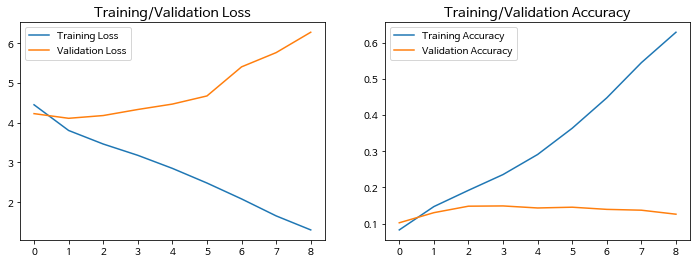

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
x = range(len(history['train_loss']))

ax1.plot(x, history['train_loss'], label='Training Loss')
ax1.plot(x, history['val_loss'], label='Validation Loss')
ax1.set_title('Training/Validation Loss', fontsize=14)
ax1.legend()

ax2.plot(x, history['train_acc'], label='Training Accuracy')
ax2.plot(x, history['val_acc'], label='Validation Accuracy')
ax2.set_title('Training/Validation Accuracy', fontsize=14)
ax2.legend()

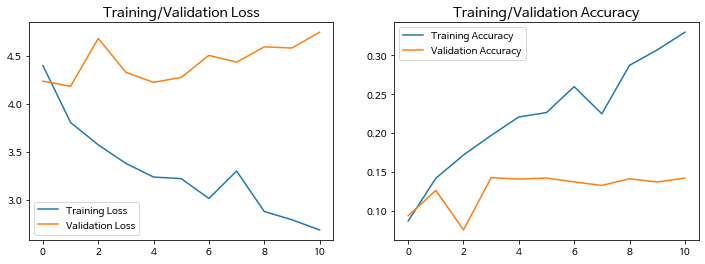

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
x = range(len(pretrained_history['train_loss']))

ax1.plot(x, pretrained_history['train_loss'], label='Training Loss')
ax1.plot(x, pretrained_history['val_loss'], label='Validation Loss')
ax1.set_title('Training/Validation Loss', fontsize=14)
ax1.legend()

ax2.plot(x, pretrained_history['train_acc'], label='Training Accuracy')
ax2.plot(x, pretrained_history['val_acc'], label='Validation Accuracy')
ax2.set_title('Training/Validation Accuracy', fontsize=14)
ax2.legend()

## STEP 6. 모델 평가
---

- Inference 함수 정의

In [66]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

- Inference 수행

In [75]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

inference_result = []

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict_no_pretrained = do_predict(model, question, context)
        answer_predict_pretrained = do_predict(pretrained_model, question, context)
        
        if answer in answer_predict_no_pretrained and answer in answer_predict_pretrained:
            inference_result.append({
                "idx" : i,
                "question" : question,
                "context" : context,
                "answer" : answer,
                "answer_predict_no_pretrained" : answer_predict_no_pretrained,
                "answer_predict_pretrained": answer_predict_pretrained
            })
        if 100 < i:
            break

In [71]:
def show_inference_result(idx):
    print(f"📌 idx : {inference_result[idx]['idx']}")
    print(f"문제 : {inference_result[idx]['question']}")
    print(f"지문 : {inference_result[idx]['context']}")
    print(f"정답 : {inference_result[idx]['answer']}")
    print(f"예측 : {inference_result[idx]['answer_predict_no_pretrained']}")
    print(f"예측-전이학습 : {inference_result[idx]['answer_predict_pretrained']}")

In [77]:
len(inference_result)

8

- Inference 수행결과 확인(0)

In [76]:
show_inference_result(0)

📌 idx : 25
문제 : 육군사관학교에서 졸업한 헤이그가 제일 처음 소위로 발령받은 부대는 무엇이었나?
지문 : 노터데임 대학교에서 2년간 합리적으로 심각한 공부를 한 후 헤이그는 1944년 미국 육군사관학교로 임명을 획득하여 자신의 어린 시절을 군사 경력의 야망으로 알아챘다. 그 경력은 헤이그의 학문적 경연이 암시하려고 한것보다 더욱 극적이었으며 그는 1947년 310의 동기병에서 217번째 사관으로서 졸업하였다. 22세의 소위로 헤이그는 처음에 캔자스 주 포트라일리에서 정통 제병 연합부대로, 그러고나서 켄터키 주 포트녹스에 있는 기갑 훈련소로 갔다. 그후에 그는 제1 기병 사단으로 선임되고 그러고나서 일본에서 점령군의 임무와 기력이 없는 훈련을 하였다. 그는 1950년 5월 한번 자신의 사령관 알론조 폭스 장군의 딸 퍼트리샤 앤토이넷 폭스와 결혼하여 슬하 3명의 자식을 두었다.
정답 : 정통 제병 연합부대
예측 : 헤이그는 처음에 캔자스 주 포트라일리에서 정통 제병 연합부대로, 그러고나서 켄터키 주 포트녹
예측-전이학습 : 정통 제병 연합부대


- Inference 수행결과 확인(1)

In [78]:
show_inference_result(1)

📌 idx : 47
문제 : 노아의 방주는 총 몇층으로 되어 있었는가?
지문 : 노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 : 3층
예측 : 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 

- Inference 수행결과 확인(2)

In [79]:
show_inference_result(2)

📌 idx : 76
문제 : 담수와 염수가 급작스럽게 섞일 경우 대부분의 수생생물이 폐사하는 원인은?
지문 : 기독교 성경 내용에는 모든 종들을 방주에 태운다고 이야기하고 있으나, 어류나 수중 생물에 대해서는 언급하지 않았다. 이것을 신학적 의미로만 받아들이면 괜찮은 문제이나, 이 현상이 실제로 일어났다고 가정할 경우,이는 종 간 생존 환경의 차이에 대해서 간과하고 있다. 수중 생물이라 하더라도 종에 따라 생존할 수 있는 환경은 각각 다른 것이며, 40일 이내에 현존하는 가장 높은 산인 에베레스트 산도 잠기게 할 정도의 폭우로 인해 담수와 염수가 급작스럽게 섞일 경우, 급격한 삼투압 변화로 인해 대부분의 수생생물들이 폐사하게 되며, 결과적으로 육지 뿐 아니라 바다와 강의 모든 생태계가 파괴된다. 이후 5천년이라는 지극히 짧은 세월 동안 지구상의 동식물이 모두 페름기 대멸종 또는 K-T 대멸종에 준하는 대량절멸에 가까운 상태에서부터 시작하여 현재의 대략 870만(±120만)종에 달하는 생물다양성을 획득하려면 모든 생물들이 각 세대마다 종분화가 일어나야 할 만큼 엄청난 속도로 진화 및 번식이 (멸종 없이) 이루어져야만 가능한 일이다. (이와 관련하여 창조과학회 측에서는 북극곰의 예시를 통해 가지고 있던 특성이 없어지는 것이 진화가 아니라고 주장하지만, 통상적으로 알려진 바와 같이 생물학에서는 이미 존재하는 특성이 없어지는 현상, 즉 퇴화 역시 진화의 정의에 포함된다.) 즉, 노아의 홍수가 실재하는 사건이었다면 진화적 종분화가 현재까지 알려진 것과 비교할 수 없이 엄청난 속도로 이루어져야만 현재 지구의 생물다양성을 설명할 수 있다. 게다가 이것은 현재의 생물종 멸종 속도를 전혀 고려하지 않았다. 다시 말해, 노아의 홍수가 실재하는 전지구적인 사건이기 위해서는 최소 캄브리아기 대폭발 수준의 폭발적인 진화적 종분화가 1-2억년이 아니라 최대 3-4천년 이내에 이루어졌어야만 현생 지구의 생물다양성에 대한 설명이 가능해진다. 그보다 더 중요한 것은, 각 동물들이 차지하는 

- Inference 수행결과 확인(3)

In [80]:
show_inference_result(3)

📌 idx : 88
문제 : 막부 해군이 정박하고 있던 시나가와 해역을 탈출한 시간은?
지문 : 1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함선으로 사용한 후, 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직전이 되었지만, 1개월만에 에노모토 해군과 합류하였다. 에조치에 건너가 하코다테 전쟁에서는 에노모토(하코다테 정부) 해군의 주력함이 되었다. 영국이 기증했을 때 엠퍼러(Emperor, 기증 당시 일본의 수장은 황제가 아니라 쇼군으로 인식되고 있었기 때문에 장군을 지칭)로 명명하고 있음에서 알 수 있듯이, 쇼군용 유람 요트로 기증되었다고 생각되지만, 세상이 그것을 허락하지 않았다. 아이러니하게도, 군함에 통합되어 실제로 쇼군이 첫 좌승한 것이 대정봉환 이후 슨푸 번에 이송되었을 때였다.
정답 : 자정
예측 : 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직전이 되었지만, 1개월만에
예측-전이학습 : 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함선으로 사용한 후, 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직

- Inference 수행결과 확인(4)

In [81]:
show_inference_result(4)

📌 idx : 93
문제 : 하코다테 전쟁 시 반류마루의 함장의 이름은 무엇인가?
지문 : 일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.
정답 : 마쓰오카 바키치
예측 : 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프
예측-전이학습 : 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부


- Inference 수행결과 확인(5)

In [82]:
show_inference_result(5)

📌 idx : 94
문제 : 반류마루가 미야코 만 해전에서 폭풍우를 만나 대기하고 있던 항구의 이름은 무엇인가?
지문 : 일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.
정답 : 하치노헤
예측 : 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프
예측-전이학습 : 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부


- Inference 수행결과 확인(6)

In [83]:
show_inference_result(6)

📌 idx : 95
문제 : 반류마루가 미야코 만 해전당시 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속하여 하치노헤 항에서 대기한 날짜는 언제인가?
지문 : 일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.
정답 : 1869년 메이지 2년 3월 25일
예측 : 1869년 메이지 2년 3월 25일
예측-전이학습 : 1869년 메이지 2년 3월 25일


- Inference 수행결과 확인(7)

In [84]:
show_inference_result(7)

📌 idx : 99
문제 : 미야코 만 해전에서 아쓰오카 바키치 함장이 폭풍우를 만난 년도는?
지문 : 일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.
정답 : 1869년
예측 : 1869년
예측-전이학습 : 1869년


## STEP 3. 결론
---

### 프로젝트 평가
1. BERT pretrained model을 활용한 KorQuAD 모델이 정상적으로 학습이 진행되었다.<br>KorQuAD 모델의 validation accuracy가 안정적으로 증가하였다.
    - validation accuracy가 약간 증가한 후 더 이상 변화가 없었다.
2. KorQuAD Inference 결과가 원래의 정답과 비교하여 유사하게 나오는 것을 확인하였다.<br>평가셋에 대해 모델 추론 결과와 실제 정답의 유사성이 확인되었다.
    - 모델 추론을 통하여 생성된 정답과 비교하였을때, 전이학습을 진행한 모델과 진행하지 않은 모델이 공통적으롣 답을 찾았다-추론 문장안에 실제 답이 포함되어 있다-고 볼 수 있는 경우가 100개의 문제에 대해 단 8건이었다. 실제 답을 완벽하게 찾아낸 경우도 있기는 하였으나 모델이 유효하다고 볼 수 있을지는 판단이 서지 않는다.
3. pretrained model 활용이 효과적임을 실험을 통해 확인하였다.<br>pretrained model을 사용하지 않았을 때 대비 학습경과의 차이를 시각화를 통해 확인하였다.
    - 전이학습을 진행하였을 때의 validation loss가 적은 범위로 상승하였다.
    - 전이학습을 사용하지 않은 모델의 경우 training accuracy가 0.6에 도달하고 있고, 이는 과접합이 되었다고 생각해도 무방할 것 같다.
    - 학습 경과를 plot로 나타내었다.

### 회고
- 트랜스포머 이후로 또 벽을 하나 더 만난 기분이었다. BERT 자체를 완전히도 아니고 겉핥기로도 이해가 부족하다는 점을 계속 계속 느끼면서 프로젝트를 수행하였다. 시간이 따로 내어 BERT에 대하여 천천히 알아보는 시간을 가져야겠다.

## ref
---
- [HanBert의 개발과 korquad 2.0 By TwoBlock Ai](slideshare.net/YoungHCHO/hanbert-korquad-20-by-twoblock-ai)
- [[기초 통계] 중앙값 (Median), IQR(InterQuartile Range, 사분범위)](https://blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221021173204)